In [75]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

## Ignis
Ignis framework that contains various functionalities such as characterization, verification and mitigation.

### Generating Noise effects of relaxation

noise type as decoherence.
3 main types of decoherence are
- $T_1$ relaxation
- $T_2/T_2^*$ dephasing

for the $T_1$ we can make a qubit in 0 and apply X gate to make it 1 and then wait for certain amount of time before measuring the qubit.

(( 1 )) insert an identity gate with a fixed gate time. and how to determine how many identity gates for that $t1_circuits()$

In [76]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors.standard_errors import amplitude_damping_error, phase_damping_error

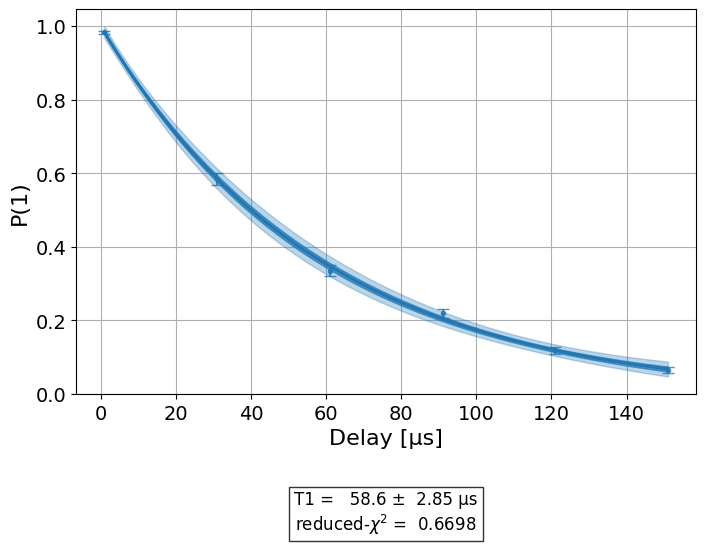

         name experiment components              value quality  \
97645f3d   T1         T1       [Q0]  (5.86+/-0.28)e-05    good   

                                 backend run_time     chisq unit  
97645f3d  aer_simulator_from(fake_perth)     None  0.669797    s  


In [77]:
import numpy as np
from qiskit_experiments.library import T1

# A T1 simulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakePerth


# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Look up target T1 of qubit-0 from device properties
qubit0_t1 = FakePerth().qubit_properties(0).t1

# Time intervals to wait before measurement
delays = np.arange(1e-6, 3 * qubit0_t1, 3e-5)
# Create an experiment for qubit 0
# with the specified time intervals
exp = T1(physical_qubits=(0,), delays=delays)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp.set_transpile_options(scheduling_method='asap')

# Run the experiment circuits and analyze the result
exp_data = exp.run(backend=backend, seed_simulator=101).block_for_results() # ----> This is T1Filter

# Print the result
display(exp_data.figure(0))
print(exp_data.analysis_results(dataframe=True)) # --> this is used for the plot

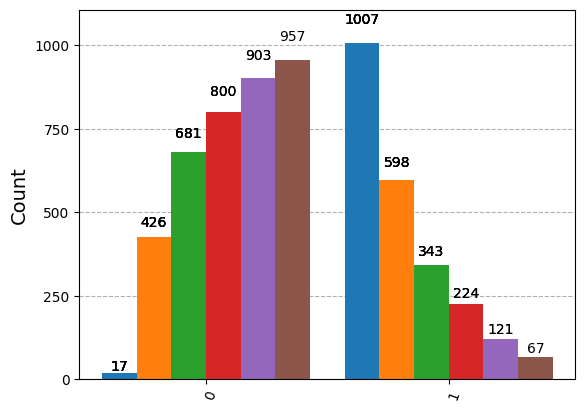

In [78]:
arr = []
for i in exp_data._result_data.__dict__.get('_container', []):
    arr.extend([i['counts']])
    # print(f"{i['job_id']} -> {i['counts']}")

import qiskit.visualization as vis
vis.plot_histogram(arr)


In [79]:
qubit0_t1

5.592927874207379e-05

In [80]:
len(exp.circuits())

6

In [81]:
delays

array([1.00e-06, 3.10e-05, 6.10e-05, 9.10e-05, 1.21e-04, 1.51e-04])

In [82]:
exp.circuits()[0].draw()

┌───┐ ░ ┌─────────────────┐ ░ ┌─┐
  q: ┤ X ├─░─┤ Delay(1e-06[s]) ├─░─┤M├
     └───┘ ░ └─────────────────┘ ░ └╥┘
c: 1/═══════════════════════════════╩═
                                    0

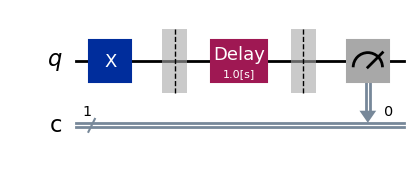

In [85]:
exp.circuits()[1].draw('mpl')

### Estimating $T_1$ decoherence time

         name experiment components                           value quality  \
2395ebb4   T1         T1       [Q0]  (-3.463434148434745+/-nan)e+17     bad   

                backend run_time chisq unit  
2395ebb4  aer_simulator     None   0.0    s  


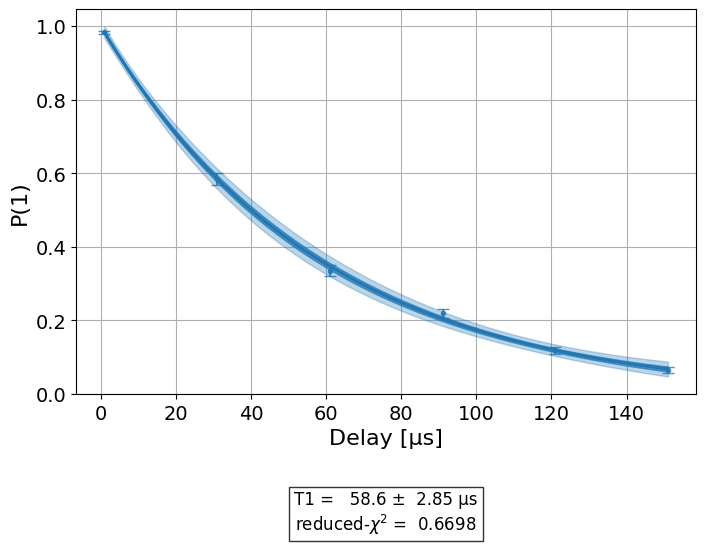

In [89]:
from qiskit_aer import AerSimulator
from qiskit_experiments.library import T1

# Create a backend (e.g., AerSimulator)
backend = AerSimulator()

# Create a T1 experiment
t1_experiment = T1(physical_qubits=[0], delays=[0.01, 0.02, 0.03])  # Example delays in seconds

# Run the experiment
result = t1_experiment.run(backend).block_for_results()

# Analyze the results
analysis_result = result.analysis_results(dataframe=True)

print(analysis_result)

display(exp_data.figure(0))

### Generating the noise effects of dephasing

$T_2^*$ represents a dephasing of a qubit. determining this is conducted
by placing the qubit in a superposition state using Hadamard gate then after some delay time
you apply another hadamard gate and measure. this should result in the qubit being in original state (**Ramsey Experiement**)

$T_2$ represents a dephasing of a qubit. determining this is conducted
by placing the qubit in a superposition state using Hadamard gate then wait until half the delay time
and then apply either an X or Y rotation then qait until the second hald deplay time is
complete before measure. (**Hahn echo Experiment**)

> It checks if the stae is in linear combination of the 2 states.

while the qubit is in $|+>$ state, this is where dephasing could be a problem the problem lies in that over time,
the qubit may or may not be in the $|+>$ or $|->$ state, but rather in some angle around the Z axis away from the $|+>$ state.
Thus making the qubit unpredictable when applying $H Gate$ if our expectation is for the $|0>$ state, we may get $|1>$ state instead.


In [102]:
from qiskit_experiments.library.characterization.t2hahn import T2Hahn

qubit = 0
conversion_factor = 1e-6 # our delay will be in micro-sec
delays = list(range(0, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]
number_of_echoes = 1

# Create a T2Hahn experiment. Print the first circuit as an example
exp1 = T2Hahn(physical_qubits=(qubit,), delays=delays, num_echoes=number_of_echoes)
exp1.circuits()[0].draw()

┌─────────┐┌───────────────┐┌───────┐┌───────────────┐┌─────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(0.0[s]) ├┤ Rx(π) ├┤ Delay(0.0[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└───────────────┘└───────┘└───────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════╩═
                                                                       0

In [91]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn = 20 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[estimated_t2hahn],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
)

In [98]:
exp1.analysis.set_options(p0=None, plot=True)
expdata1 = exp1.run(backend=backend, shots=2000, seed_simulator=101)
res = expdata1.block_for_results()  # Wait for job/analysis to finish.

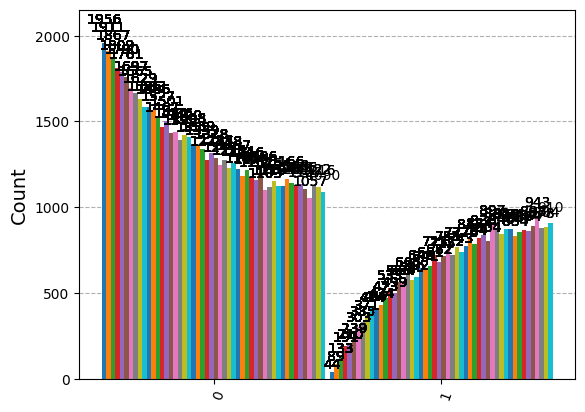

In [99]:
arr = []
for i in expdata1._result_data.__dict__.get('_container', []):
    arr.extend([i['counts']])
    # print(f"{i['job_id']} -> {i['counts']}")

# x = arr[:3] + arr[int(len(arr)/2):int(len(arr)/2)+3] + arr[-3:]

vis.plot_histogram(arr)

> As with the increasing dephasing time affect our result so we need to mitigate this errors

### Estimating $T_2$ decoherence time

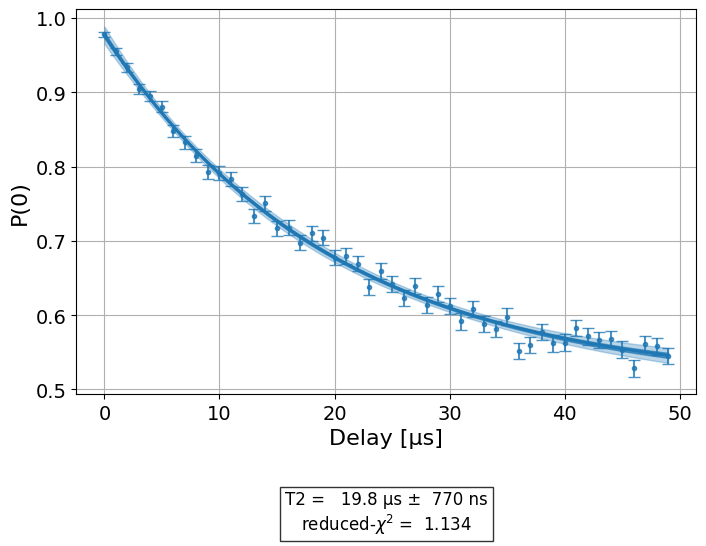

         name experiment components              value quality  \
7a0b4051   T2     T2Hahn       [Q0]  (1.98+/-0.08)e-05    good   

                   backend run_time     chisq unit  
7a0b4051  T2Hahn_simulator     None  1.133701    s  


In [97]:

# Display the figure
display(res.figure(0))
print(res.analysis_results(dataframe=True)) # Estimation!!!!


$$
S(t) = A \, e^{-t/T_2} + B
$$

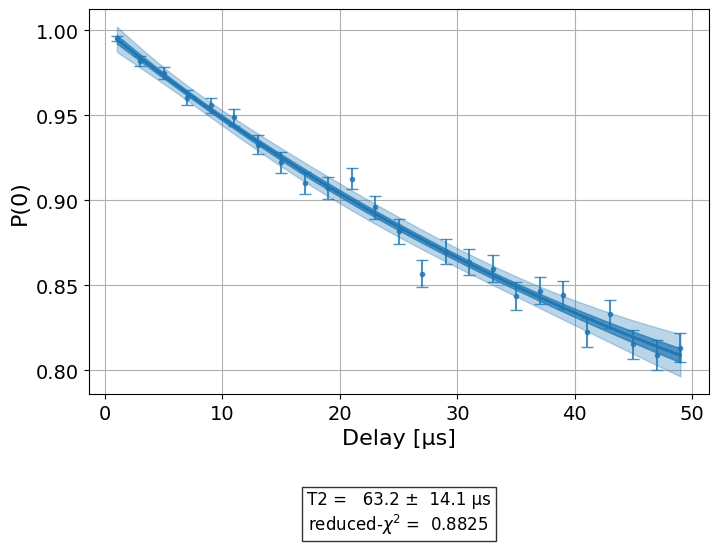

In [106]:
exp_with_p0 = T2Hahn(physical_qubits=(qubit,), delays=delays, num_echoes=number_of_echoes)
exp_with_p0.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn, "base": 0.5})
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000, seed_simulator=101)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

### Estimating $T_2^*$ decoherence time
will use Y gate

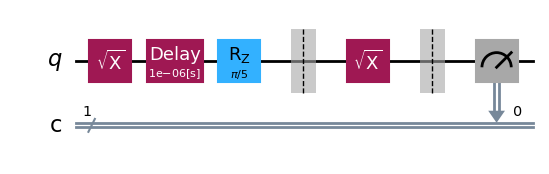

In [104]:
import numpy as np
from qiskit_experiments.library import T2Ramsey

qubit = 0
# set the desired delays
delays = list(np.arange(1e-6, 50e-6, 2e-6))
# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Ramsey((qubit,), delays, osc_freq=1e5)

exp1.circuits()[0].draw('mpl')

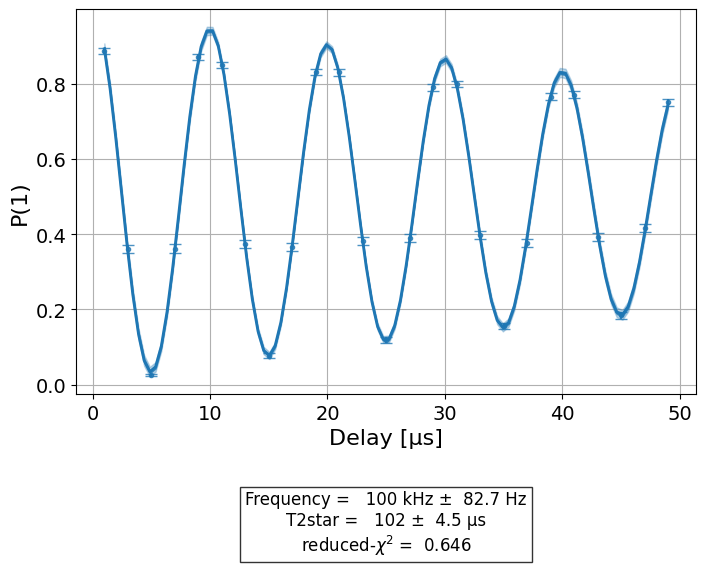

               name experiment components                value quality  \
ad31a25e  Frequency   T2Ramsey       [Q0]  (9.995+/-0.008)e+04    good   
a4e2e9b2     T2star   T2Ramsey       [Q0]  0.000102+/-0.000005    good   

                                 backend run_time    chisq unit  
ad31a25e  aer_simulator_from(fake_perth)     None  0.64604   Hz  
a4e2e9b2  aer_simulator_from(fake_perth)     None  0.64604    s  


In [105]:
# A T1 simulator
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp1.set_transpile_options(scheduling_method='asap')

# Run experiment
expdata1 = exp1.run(backend=backend, shots=2000, seed_simulator=101)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))
print(expdata1.analysis_results(dataframe=True)) # Estimation!!!!

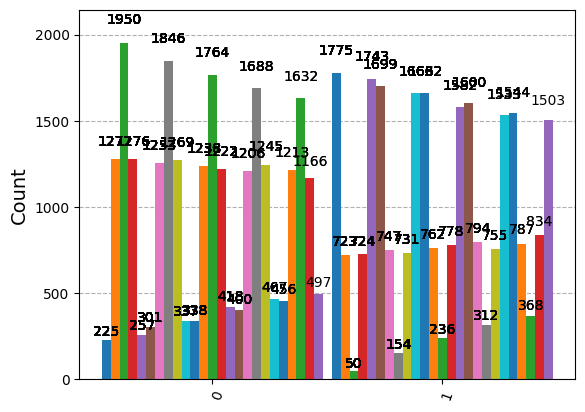

In [120]:
arr = []
for i in expdata1._result_data.__dict__.get('_container', []):
    arr.extend([i['counts']])
    # print(f"{i['job_id']} -> {i['counts']}")

# x = arr[:3] + arr[int(len(arr)/2):int(len(arr)/2)+3] + arr[-3:]
seperator = [{'0': 0, '1':0}]
vis.plot_histogram(arr) # random results which oscillate

$$
S(t) = A \, e^{-t/T_2^*} \cos(\omega t + \phi) + B
$$

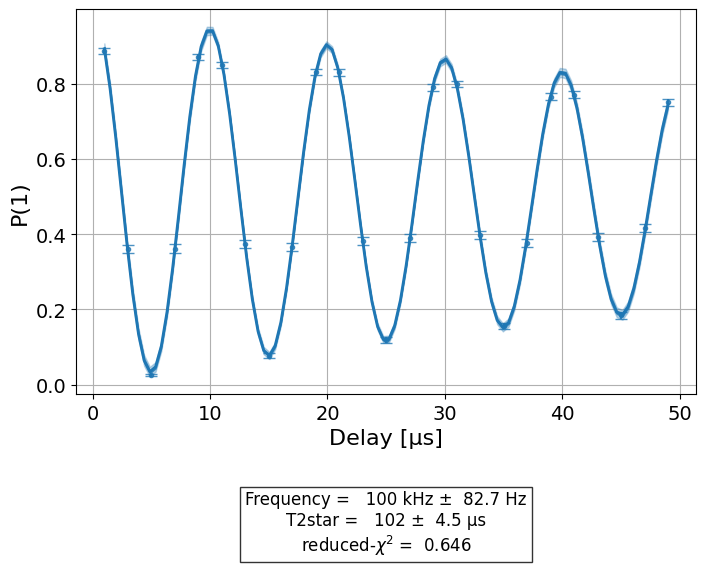

In [122]:
user_p0={
    "A": 0.5,
    "T2star": 20e-6,
    "f": 110000,
    "phi": 0,
    "B": 0.5
        }
exp_with_p0 = T2Ramsey((qubit,), delays, osc_freq=1e5)
exp_with_p0.analysis.set_options(p0=user_p0)
exp_with_p0.set_transpile_options(scheduling_method='asap')
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000, seed_simulator=101)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

### Visualizing the $T_1$, $T_2$, and $T_2^*$ decoherence times
$\frac{1}{T_\varphi} = \frac{1}{T_2} - \frac{1}{2T_1}$

We therefore create a composite experiment consisting of a $T_1$ experiment and a
$T_2$ experiment. Both Ramsey and Hahn echo experiments can be used here, with
different effects. The $T_2^*$ estimate of the Ramsey experiment is sensitive to
inhomogeneous broadening, low-frequency fluctuations that vary between experiments due
to $1/f$-type noise. The $T_{2}$ estimate from the Hahn echo (defined as
$T_{2E}$) is less sensitive to inhomogeneous broadening due to its
refocusing pulse, and so it is strictly larger than $T_2^*$ on a real device. In
superconducting qubits, $T_2^*$ tends to be significantly smaller than
$T_1$, so $T_2$ is usually used.


In [127]:
import numpy as np
import qiskit
from qiskit_experiments.library.characterization import Tphi


# An Aer simulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakePerth

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Time intervals to wait before measurement for t1 and t2
delays_t1 = np.arange(1e-6, 300e-6, 10e-6)
delays_t2 = np.arange(1e-6, 50e-6, 2e-6)

"""
By default, the Tphi experiment will use the Hahn echo experiment for its transverse relaxation time estimate.
"""

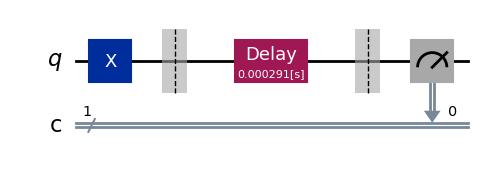

In [129]:
exp = Tphi(physical_qubits=(0,), delays_t1=delays_t1, delays_t2=delays_t2, num_echoes=1)
exp.component_experiment(0).circuits()[-1].draw(output="mpl", style="iqp")

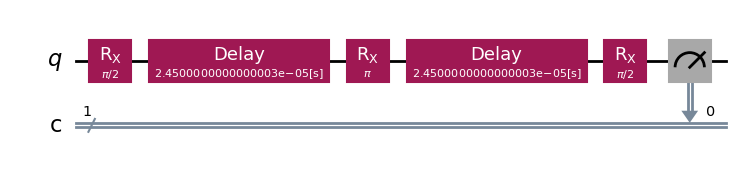

In [130]:
exp.component_experiment(1).circuits()[-1].draw(output="mpl", style="iqp")

In [131]:
expdata = exp.run(backend=backend, seed_simulator=100).block_for_results()
display(expdata.analysis_results("T_phi", dataframe=True))

,name,experiment,components,value,quality,backend,run_time,unit,chisq
33d31068,T_phi,Tphi,[Q0],-0.0004+/-0.0008,bad,aer_simulator_from(fake_perth),None,s,None


,name,experiment,components,value,quality,backend,run_time,unit,chisq
9b063a16,T1,T1,[Q0],(5.59+/-0.08)e-05,good,aer_simulator_from(fake_perth),None,s,1.247985


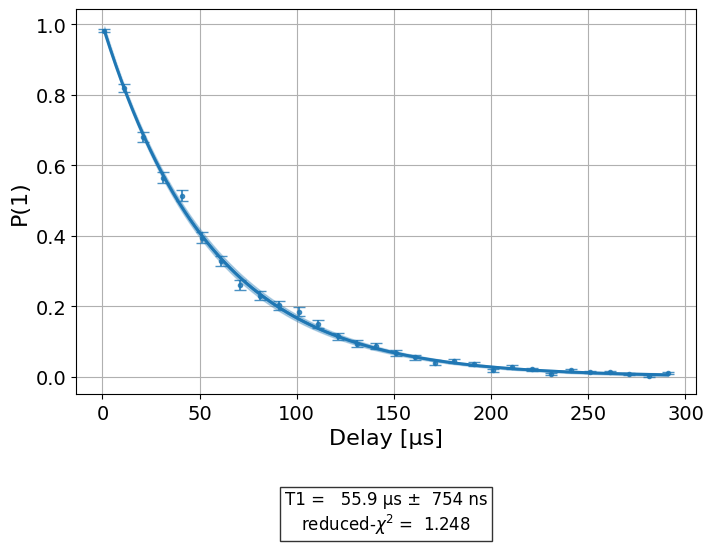

In [132]:
display(expdata.analysis_results("T1", dataframe=True))
display(expdata.figure(0))

,name,experiment,components,value,quality,backend,run_time,unit,chisq
14dcb024,T2,T2Hahn,[Q0],0.00015+/-0.00011,bad,aer_simulator_from(fake_perth),None,s,1.502093


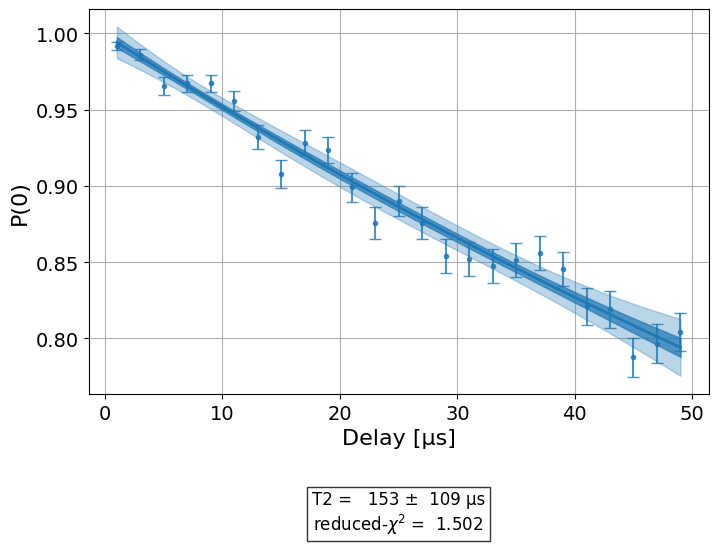

In [133]:
display(expdata.analysis_results("T2", dataframe=True))
display(expdata.figure(1))

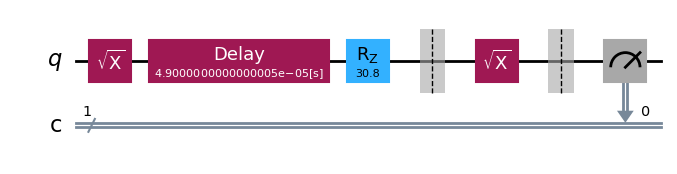

In [134]:
exp = Tphi(physical_qubits=(0,),
           delays_t1=delays_t1,
           delays_t2=delays_t2,
           t2type="ramsey",
           osc_freq=1e5)

exp.component_experiment(1).circuits()[-1].draw(output="mpl", style="iqp")

,name,experiment,components,value,quality,backend,run_time,unit,chisq
5b3ec5f6,T_phi,Tphi,[Q0],0.00053+/-0.00017,good,aer_simulator_from(fake_perth),None,s,None


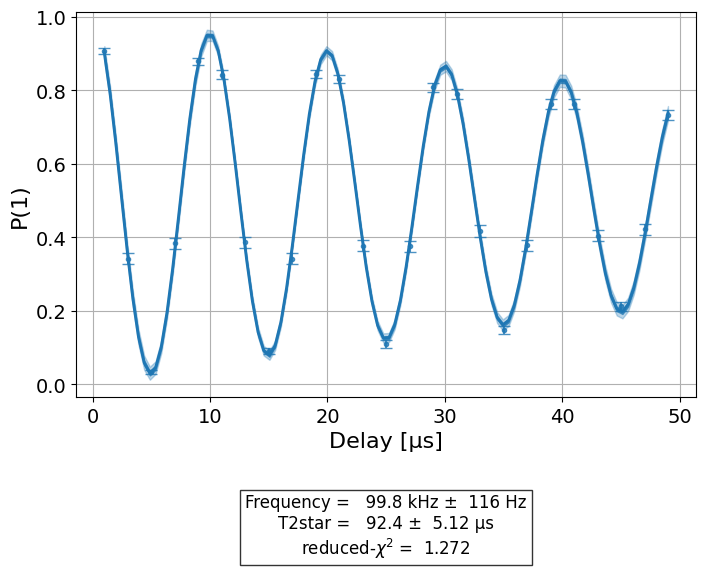

In [135]:
expdata = exp.run(backend=backend, seed_simulator=100).block_for_results()
display(expdata.analysis_results("T_phi", dataframe=True))
display(expdata.figure(1))

### Mitigating readout errors using measurement calibrations


